<a href="https://colab.research.google.com/github/kaukab/Git/blob/master/11_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-gpu

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 450kB 66.0MB/s 
     |████████████████████████████████| 3.8MB 68.8MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
time = np.arange(0, 100, 0.1)
sin = np.sin(time) + np.random.normal(scale=0.5, size=len(time))

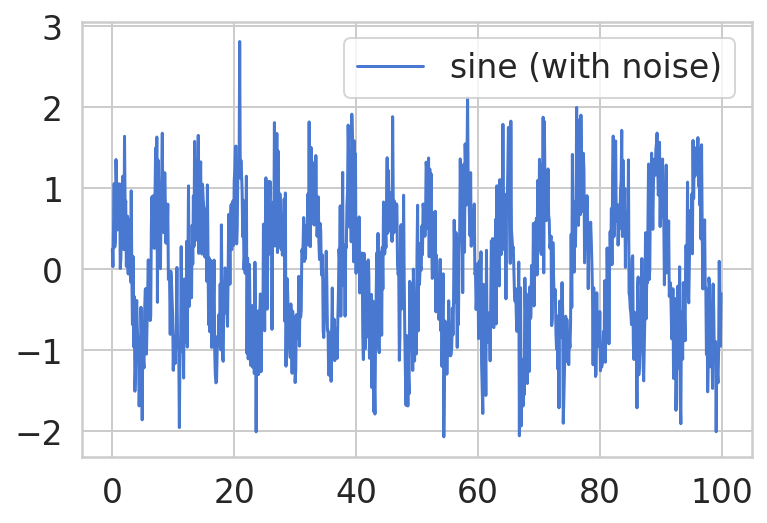

In [3]:
plt.plot(time, sin, label='sine (with noise)');
plt.legend();

# Data Preprocessing

In [17]:
df = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
df['holiday'] = np.repeat([0.0,0.0,0.0,0.0,0.5,1,1], 145)[0:1000]
df.head()

,sine,holiday
0.0,0.248357,0.0
0.1,0.030701,0.0
0.2,0.522514,0.0
0.3,1.057035,0.0
0.4,0.272342,0.0


In [18]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


In [15]:
holiday.shape
train.iloc[0:(0 + 10)].values

array([[0.24835708],
       [0.03070127],
       [0.5225136 ],
       [1.05703513],
       [0.27234165],
       [0.36235706],
       [1.35424888],
       [1.02793505],
       [0.4826189 ],
       [1.05460693]])

In [19]:
def create_dataset(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [20]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape)

(790, 10, 2) (790,)


In [21]:
X_train[0]

array([[0.24835708, 0.        ],
       [0.03070127, 0.        ],
       [0.5225136 , 0.        ],
       [1.05703513, 0.        ],
       [0.27234165, 0.        ],
       [0.36235706, 0.        ],
       [1.35424888, 0.        ],
       [1.02793505, 0.        ],
       [0.4826189 , 0.        ],
       [1.05460693, 0.        ]])

In [22]:
y_train[0]

0.6097621384016654

# Modeling

In [23]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

## Training

In [24]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Epoch 1/30
45/45 [==============================] - 6s 12ms/step - loss: 0.4401 - val_loss: 0.3736
Epoch 2/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3328 - val_loss: 0.3296
Epoch 3/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3222 - val_loss: 0.3232
Epoch 4/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3201 - val_loss: 0.3205
Epoch 5/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3187 - val_loss: 0.3183
Epoch 6/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3175 - val_loss: 0.3166
Epoch 7/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3166 - val_loss: 0.3154
Epoch 8/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3159 - val_loss: 0.3145
Epoch 9/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3152 - val_loss: 0.3138
Epoch 10/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3145 - val_loss: 0.3134
Epoch 11/30
45/45 

## Evaluation

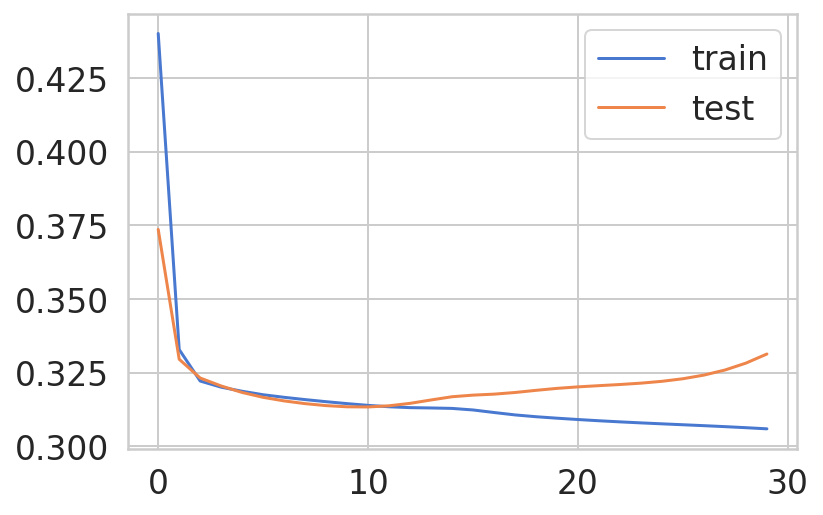

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [26]:
y_pred = model.predict(X_test)

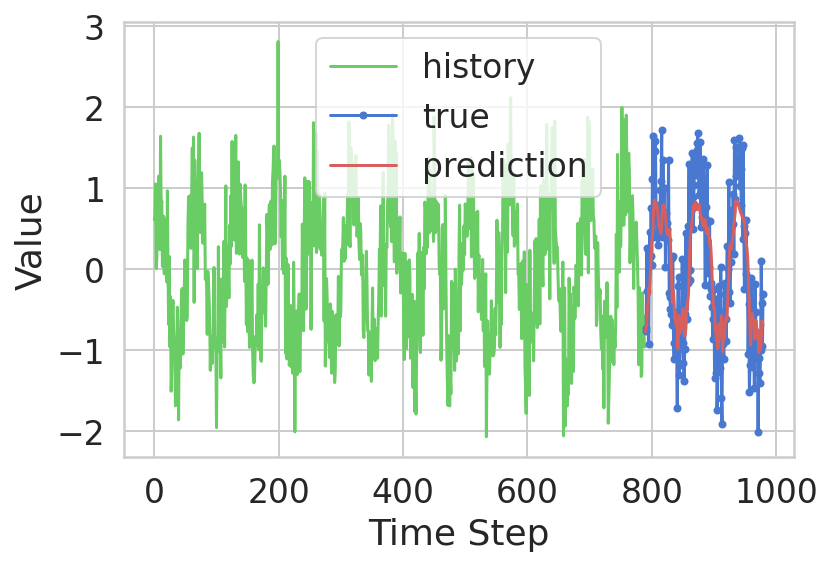

In [27]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

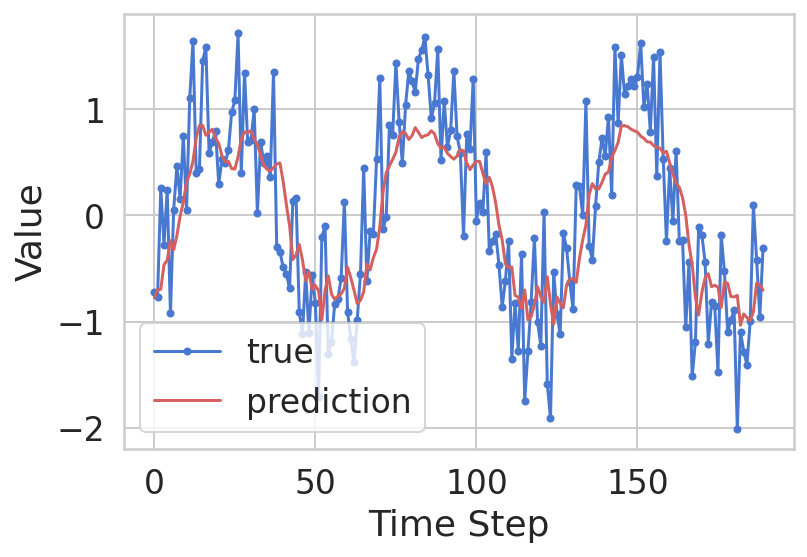

In [28]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();